In [1]:
import sys
sys.path.append('../../../')
sys.path.append('../../../examples/')
sys.path.append('../../performance_tools/')

In [2]:
import os
import pickle
import logging

import numpy as np
import pandas as pd

from dumb_containers import evaluate_performance

import torch
import torch.nn as nn
from torch.nn import NLLLoss

from argparse import Namespace
from tqdm import tqdm

from pytorch_pretrained_bert.modeling_fine_tune import BertForPairWiseClassification
from run_classifier_dataset_utils_fine_tune import LCQMCProcessor, compute_metrics, output_modes
from run_classifier_dataset_utils_fine_tune import convert_examples_to_features_fine_tune as convert_examples_to_features
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from pytorch_pretrained_bert.tokenization import BertTokenizer

In [3]:
FINE_TUNED_PATH = '/efs/fine_tune/lcqmc/pairwise/lcqmc_fine_tune_40_1_3_5e-6/'
task_name = 'lcqmc'
output_mode = output_modes[task_name]

args = Namespace(data_dir = '/efs/projects/bert_fine_tune/fine_tune/data/train_dev_test/ATEC_CCKS/processed',
                 bert_model = '/efs/downloads/bert/pytorch/bert_base_chinese',
                 max_seq_length = 40,
                 local_rank = -1,
                 eval_batch_size = 8,
                 do_train = False
                )

logger = logging.getLogger("LCQMC_pairwise_eval")

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.DEBUG)

In [4]:
device = torch.device('cuda')
processor = LCQMCProcessor()
tokenizer = BertTokenizer.from_pretrained(FINE_TUNED_PATH)
model = BertForPairWiseClassification.from_pretrained(FINE_TUNED_PATH)
model.to(device)

07/18/2019 08:24:48 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file /efs/fine_tune/lcqmc/pairwise/lcqmc_fine_tune_40_1_3_5e-6/vocab.txt
07/18/2019 08:24:48 - INFO - pytorch_pretrained_bert.modeling_fine_tune -   loading weights file /efs/fine_tune/lcqmc/pairwise/lcqmc_fine_tune_40_1_3_5e-6/pytorch_model.bin
07/18/2019 08:24:48 - INFO - pytorch_pretrained_bert.modeling_fine_tune -   loading configuration file /efs/fine_tune/lcqmc/pairwise/lcqmc_fine_tune_40_1_3_5e-6/config.json
07/18/2019 08:24:48 - INFO - pytorch_pretrained_bert.modeling_fine_tune -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layer

BertForPairWiseClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediat

In [5]:
label_list = processor.get_labels()
num_labels = len(label_list)
# eval_examples = processor.get_dev_examples(args.data_dir)
eval_examples = processor.get_test_examples(args.data_dir)

# cached_eval_features_file = os.path.join(args.data_dir, 'test_{0}_{1}_{2}'.format(
#             list(filter(None, args.bert_model.split('/'))).pop(),
#                         str(args.max_seq_length),
#                         str(task_name)))
# try:
#     with open(cached_eval_features_file, "rb") as reader:
#         eval_features = pickle.load(reader)
# except:
#     eval_features = convert_examples_to_features(
#         eval_examples, label_list, args.max_seq_length, tokenizer, output_mode)
#     if args.local_rank == -1 or torch.distributed.get_rank() == 0:
#         logger.info("  Saving eval features into cached file %s", cached_eval_features_file)
#         with open(cached_eval_features_file, "wb") as writer:
#             pickle.dump(eval_features, writer)

eval_features = convert_examples_to_features(
    eval_examples, label_list, args.max_seq_length, tokenizer, output_mode)
            
all_input_ids_a = torch.tensor([f.input_ids_a for f in eval_features], dtype=torch.long)
all_input_mask_a = torch.tensor([f.input_mask_a for f in eval_features], dtype=torch.long)
all_segment_ids_a = torch.tensor([f.segment_ids_a for f in eval_features], dtype=torch.long)

all_input_ids_b = torch.tensor([f.input_ids_b for f in eval_features], dtype=torch.long)
all_input_mask_b = torch.tensor([f.input_mask_b for f in eval_features], dtype=torch.long)
all_segment_ids_b = torch.tensor([f.segment_ids_b for f in eval_features], dtype=torch.long)

all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)

eval_data = TensorDataset(all_input_ids_a,
                          all_input_ids_b,
                          all_input_mask_a,
                          all_input_mask_b,
                          all_segment_ids_a,
                          all_segment_ids_b,
                          all_label_ids)

eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)

model.eval()
eval_loss = 0
nb_eval_steps = 0
preds = []
out_label_ids = None

for (input_ids_a, input_ids_b,
     input_mask_a, input_mask_b,
     segment_ids_a, segment_ids_b,
     label_ids
    ) in tqdm(eval_dataloader, desc="Evaluating"):
    input_ids_a = input_ids_a.to(device)
    input_mask_a = input_mask_a.to(device)
    segment_ids_a = segment_ids_a.to(device)

    input_ids_b = input_ids_b.to(device)
    input_mask_b = input_mask_b.to(device)
    segment_ids_b = segment_ids_b.to(device)

    label_ids = label_ids.to(device)

    with torch.no_grad():
        cos_sim, pos_prob, pout1, pout2 = model(input_ids_1 = input_ids_a,
                                        input_ids_2 = input_ids_b,
                                        token_type_ids_1=segment_ids_a,
                                        token_type_ids_2=segment_ids_b,
                                        attention_mask_1=input_mask_a,
                                        attention_mask_2=input_mask_b,)
        neg_prob = 1 - pos_prob
            
        probs = torch.stack([neg_prob, pos_prob], dim = 1)
        log_probs = torch.log(probs)
        
    loss_fct = NLLLoss()
    tmp_eval_loss = loss_fct(log_probs.view(-1, num_labels), label_ids.view(-1))
    if tmp_eval_loss.mean().item() == np.inf:
        logger.debug("invalid loss")
        print(cos_sim, probs)
        print(input_ids_a)
        print(input_ids_b)
        break
    
    eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1
    if len(preds) == 0:
        preds.append(probs.detach().cpu().numpy())
        out_label_ids = label_ids.detach().cpu().numpy()
    else:
        preds[0] = np.append(
            preds[0], probs.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(
            out_label_ids, label_ids.detach().cpu().numpy(), axis=0)

eval_loss = eval_loss / nb_eval_steps

07/18/2019 08:25:01 - INFO - run_classifier_dataset_utils_fine_tune -   Writing example 0 of 10000
07/18/2019 08:25:01 - INFO - run_classifier_dataset_utils_fine_tune -   *** Example ***
07/18/2019 08:25:01 - INFO - run_classifier_dataset_utils_fine_tune -   guid: test-0
07/18/2019 08:25:01 - INFO - run_classifier_dataset_utils_fine_tune -   tokens_a: [CLS] 一 个 身 份 证 号 吗 两 个 支 付 宝 账 号 花 呗 可 以 同 时 使 用 吗 [SEP]
07/18/2019 08:25:01 - INFO - run_classifier_dataset_utils_fine_tune -   tokens_b: [CLS] 如 何 让 淘 宝 可 以 使 用 支 付 宝 的 花 呗 [SEP]
07/18/2019 08:25:01 - INFO - run_classifier_dataset_utils_fine_tune -   input_ids_a: 101 671 702 6716 819 6395 1384 1408 697 702 3118 802 2140 6572 1384 5709 1446 1377 809 1398 3198 886 4500 1408 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
07/18/2019 08:25:01 - INFO - run_classifier_dataset_utils_fine_tune -   input_ids_b: 101 1963 862 6375 3905 2140 1377 809 886 4500 3118 802 2140 4638 5709 1446 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
07/18/2019 08:25:01 - IN

In [6]:
preds = preds[0]
probs = preds[:,1]
pred_outs = np.argmax(preds, axis=1)
result = compute_metrics(task_name, pred_outs, out_label_ids)

loss = tr_loss/global_step if args.do_train else None

result['eval_loss'] = eval_loss
# result['global_step'] = global_step
result['loss'] = loss

# output_eval_file = os.path.join(args.output_dir, "eval_results.txt")
logger.info("***** Eval results *****")
for key in sorted(result.keys()):
    logger.info("  %s = %s", key, str(result[key]))
#         writer.write("%s = %s\n" % (key, str(result[key])))

07/18/2019 08:27:33 - INFO - LCQMC_pairwise_eval -   ***** Eval results *****
07/18/2019 08:27:33 - INFO - LCQMC_pairwise_eval -     acc = 0.4701
07/18/2019 08:27:33 - INFO - LCQMC_pairwise_eval -     acc_and_f1 = 0.49239957413682567
07/18/2019 08:27:33 - INFO - LCQMC_pairwise_eval -     eval_loss = 0.8310629919528961
07/18/2019 08:27:33 - INFO - LCQMC_pairwise_eval -     f1 = 0.5146991482736514
07/18/2019 08:27:33 - INFO - LCQMC_pairwise_eval -     loss = None


KS=0.184, AUC=0.63, N=10000
At threshold=0.339, TPR=0.46, 1554 out of 3392
At threshold=0.339, TPR=0.28, 1837 out of 6608
Ave_target: [0.214 0.254 0.258 0.295 0.296 0.312 0.344 0.382 0.431 0.606]
Ave_predicted: [0.31855357 0.43386492 0.50129133 0.55768621 0.61215854 0.66196167
 0.71100438 0.76410782 0.82564759 0.9147532 ]


../../performance_tools/dumb_containers.py:378: MatplotlibDeprecationWarning: The find function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  maxind = plb.find(tpr-fpr == ks)
../../performance_tools/dumb_containers.py:382: MatplotlibDeprecationWarning: The find function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  minind = plb.find(abs(cum_total - event_rate) == min(abs(cum_total - event_rate)))


0.1842784903376125

07/18/2019 08:27:33 - DEBUG - matplotlib.axes._base -   update_title_pos
07/18/2019 08:27:33 - DEBUG - matplotlib.font_manager -   findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/root/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
07/18/2019 08:27:33 - DEBUG - matplotlib.font_manager -   findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0 to DejaVu Sans ('/root/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
07/18/2019 08:27:33 - DEBUG - matplotlib.axes._base -   update_title_pos
07/18/2019 08:27:33 - DEBUG - matplotlib.axes._base -   update_title_pos
07/18/2019 08:27:33 - DEBUG - matplotlib.axes._base -   update_title_pos
07/18/2019 08:27:33 - DEBUG - matplotlib.axes._base -   update_title_pos
07/18/2019 08:27:33 - DEBUG - matplotlib.axes

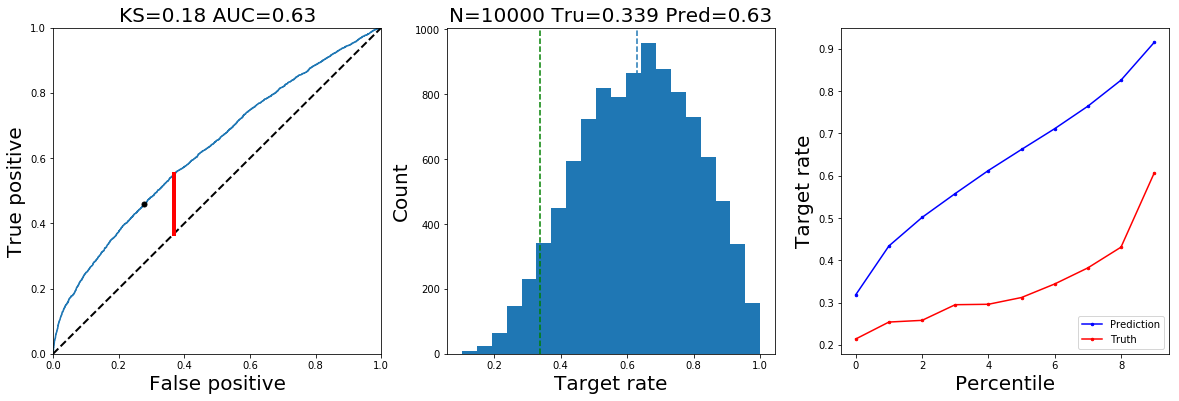

In [7]:
gt = all_label_ids.numpy()
evaluate_performance(gt, probs)